### ⚠ IMPORTANT ⚠

You will need at least 15GB of VRAM (GPU RAM) to run this notebook. 1

If you're running this locally - please ensure you have the correct hardware to support the fine-tuning.

# Session_10_Daniel_Gutierrez

> [Add blockquote](https://)

**** NOTE TO GRADER ****

This notebook was completed in Google Collaboration PRO and downloaded to local system, then upload to my Github Repo. ** **bold text

# Task Fine-tuning a GPT-style model using `peft`, `transformers` and `bitsandbytes`

In the following notebook, we'll task fine-tune a GPT-style model on the summarization task using:

- [QLoRA](https://arxiv.org/pdf/2305.14314.pdf)/[LoRA](https://arxiv.org/pdf/2106.09685.pdf)

The basic idea is that we will fine-tune an "adapter" which will represent a small subset of trainable weights on our task. This will allow us to instruct-tune a comparatively large model with consumer level resources.

The model we'll be instruct-tuning today is [`NousResearch/Meta-Llama-3-8B-Instruct`](https://huggingface.co/NousResearch/Meta-Llama-3-8B-Instruct)!

> NOTE: The official Llama 3 weights are gated behind a EULA - while using the NousResearch version does not change the acceptable use of the model, it does shortcut needing to wait for the EULA to be accepted.

### Homework Sections

The notebook will be broken into the following sections:

1. Breakout Room #1:
  - Task #1: Loading the Model
2. Breakout Room #2:
  - Task #2: Data and Data Prep.
  - Task #3: Setting up PEFT LoRA
  - Task #4: Training the Model
  - Task #5: Share Your Model!

There are a total of 6 Questions, and 1 Activity, all of which must be completed to receive full marks for the homework.


#### ❓Question #1:

What makes Llama 3 8B Instruct a good model to use for a summarization task?

**ANSWER:**

Llama 3 8B Instruct is great for summarization because it's specially trained for dialogue and performs better than many open-source chat models in industry tests. It’s an auto-regressive language model with an improved transformer design. The model is fine-tuned using both supervised learning and reinforcement learning with human feedback to make it more helpful and safe.

### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

# 🤝 Breakout Room #1

### Setting Up Dependencies

We'll start by setting up the dependencies!

In [1]:
!pip install -qU bitsandbytes datasets accelerate loralib peft transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatibl

We'll first verify we're in a GPU instance.

In [2]:
import torch
torch.cuda.is_available()

True

Time to import some dependencies!

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 40GB GPU.
- `bnb_4bit_quant_type` - setting this to the desired format of `nf4` will ensure we're using the most memory efficient datatype for 4bit storage.
- `bnb_double_quant` - setting this to true will save us memory by quantizing the quantization config
- `bnb_4bit_compute_dtype` - since we will not use a 4-bit representation to compute, we need to provide a desired format for our compute type so our weights can be upcast to something while we flow information through our network.



In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

#### ❓Question #2:

What exactly is happening in the double quantization step?

> NOTE: You can use the paper provided to find the answer!


**ANSWER:**

Double quantization is a technique designed to further decrease the memory footprint of quantized models by applying quantization to the constants used in the initial quantization process. Essentially, this involves quantizing these constants to an even lower precision, thereby reducing the number of bits needed for their storage. By doing so, the model's overall size is reduced, which can lead to faster inference times and more efficient use of memory. This approach allows for more compact models without significantly impacting performance, making it a valuable method for optimizing resource-intensive machine learning applications.

Now we can load the model.

In [5]:
model_id = "NousResearch/Meta-Llama-3.1-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [7]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

### Model Architecture

It's important to observe the model's construction!

This one should look familiar!

In [8]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [9]:
model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false

#### ❓Question #3:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `NousResearch/Meta-Llama-3-8B-Instruct`'s architecture.

- EXAMPLE - Layer Norm:
  - `(input_layernorm): LlamaRMSNorm()`
  - `(post_attention_layernorm): LlamaRMSNorm()`
  - `(norm): LlamaRMSNorm()`
- Feed Forward:
  - `(mlp.gate_proj): Linear4bit()`
  - `(mlp.down_proj): Linear4bit()`
  - `(mlp.up_proj): Linear4bit()`
- Masked Multi Self-Attention:
  - `(self_attn.q_proj): Linear4bit()`
  - `(self_attn.k_proj): Linear4bit()`
  - `(self_attn.v_proj): Linear4bit()`
  - `(self_attn.o_proj): Linear4bit()`
- Text & Position Embed:
  - `(embed_tokens): Embedding()`
- Text Prediction:
  - `(lm_head): Linear()`





# 🤝 Breakout Room #2

## Task #2: Data and Data Preparation

Since we'll be focusing on summarization fine-tuning - we'll need to find a summarization dataset!

There are a few good examples available to use on the Hugging Face [dataset](https://huggingface.co/datasets?task_categories=task_categories:summarization&sort=trending) hub - let's check a few of them out!

> NOTE: The link above is pre-filtered to include datasets with the summarization tag

### Summarization Datasets

Let's see what is available for us:

- [`databricks/databricks-dolly-15k`](https://huggingface.co/datasets/databricks/databricks-dolly-15k)
  - this dataset is comprised of ~15K rows of various tasks of which ~7% is summarization data
- [`samsum`](https://huggingface.co/datasets/samsum)
  - this dataset contains ~16K conversations in messenger format as well as their summaries
- [`CohereForAI/aya_collection`](https://huggingface.co/datasets/CohereForAI/aya_collection)
  - similar to Dolly-15K, this dataset contains a wide range of *multilingual* tasks - a subset of which is summarization
- [`Plain English Summary of Contracts`](https://github.com/lauramanor/legal_summarization)
  - contains legal document (EULA, TOS, etc) and natural language summary pairs.

Today we'll be using the Plain English Summary of Contracts dataset to fine-tune Llama 3 8B Instruct to provide natural language descriptions of Legal Documents!

The first step will be to download the dataset from GitHub!

In [10]:
!git clone https://github.com/lauramanor/legal_summarization

Cloning into 'legal_summarization'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 31 (delta 2), reused 0 (delta 0), pack-reused 25 (from 1)
Receiving objects: 100% (31/31), 136.60 KiB | 1013.00 KiB/s, done.
Resolving deltas: 100% (10/10), done.


Then we can load it into a list of JSON objects.

In [11]:
import json

jsonl_array = []

with open('legal_summarization/tldrlegal_v1.json') as f:
  data = json.load(f)
  for key, value in data.items():
    jsonl_array.append(value)

Finally we can convert our list of JSON objects to a dataset quickly and effectively using the Hugging Face [`datasets`](https://huggingface.co/docs/datasets/en/index) library!

In [12]:
from datasets import Dataset, load_dataset

legal_dataset = Dataset.from_list(jsonl_array)

Let's check how many items we have in each of our training, validation, and test subsets.

In [13]:
legal_dataset

Dataset({
    features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
    num_rows: 85
})

We can now format our dataset into a training test split!

In [14]:
legal_dataset = legal_dataset.train_test_split(test_size=0.2)

In [15]:
legal_dataset_test_valid = legal_dataset["test"].train_test_split(test_size=0.5)

In [16]:
from datasets import DatasetDict

legal_dataset = DatasetDict({
    "train" : legal_dataset["train"],
    "test" : legal_dataset_test_valid["test"],
    "validation" : legal_dataset_test_valid["train"]
})

In [17]:
legal_dataset

DatasetDict({
    train: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 68
    })
    test: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 8
    })
})

Let's look at a single example to see the format we're working with!

In [18]:
legal_dataset["train"][0]

{'doc': 'Android SDK License Agreement (June 2014)',
 'id': '543ed49a98d9d5a17e000263',
 'original_text': 'if you use any api to retrieve data from google you acknowledge that the data may be protected by intellectual property rights which are owned by google or those parties that provide the data or by other persons or companies on their behalf. your use of any such api may be subject to additional terms of service. you may not modify rent lease loan sell distribute or create derivative works based on this data either in whole or in part unless allowed by the relevant terms of service.',
 'reference_summary': 'data provided by google may be protected.',
 'title': '8.1.1',
 'uid': 'legalsum56'}

### Instruction Templating

Instruction-tuned LLMs will typically use a specific template when being trained to accomodate various instruction sets, as well as for better chat and multi-turn use-cases.

Here is the format as indicated in Meta's [llama3](https://github.com/meta-llama/llama3?tab=readme-ov-file#instruction-tuned-models) repository, as well as the intuition behind the prompt template.

> The fine-tuned models were trained for dialogue applications. To get the expected features and performance for them, a specific formatting defined in ChatFormat needs to be followed: The prompt begins with a `<|begin_of_text|>` special token, after which one or more messages follow. Each message starts with the `<|start_header_id|>` tag, the role `system`, `user` or `assistant`, and the `<|end_header_id|>` tag. After a double newline `"\n\n"` the contents of the message follow. The end of each message is marked by the `<|eot_id|>` token.

Here is an example of this format:

```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]
welcome to the pokémon go video game services which are accessible via the niantic inc niantic mobile device application the app. to make these pokémon go terms of service the terms easier to read our video game services the app and our websites located at http pokemongo nianticlabs com and http www pokemongolive com the site are collectively called the services. please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.
[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>

hi.<|eot_id|>
```

> NOTE: We're adding our own special tokens here in `[LEGAL_DOC]` and `[END_LEGAL_DOC]` to encourage the model to better understand our context, but these are not special tokens that are already understood by the model.

#### 🏗️ Activity #1: Creating the `create_prompt` function

We'll create a function that will take a row of our dataset, along with a default False flag that creates the prompt in the format expressed above.

In [19]:
INSTRUCTION_PROMPT_TEMPLATE = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a short human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]{LEGAL_TEXT}[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

RESPONSE_TEMPLATE = """\
{NATURAL_LANGUAGE_SUMMARY}<|eot_id|><|end_of_text|>"""

In [20]:
def create_prompt(sample, include_response = True):
  """
  Parameters:
    - sample: dict representing row of dataset
    - include_response: bool

  Functionality:
    This function should build the Python str `full_prompt`.

    If `include_response` is true, it should include the summary -
    else it should not contain the summary (useful for prompting) and testing

  Returns:
    - full_prompt: str
  """
  full_prompt = INSTRUCTION_PROMPT_TEMPLATE.format(LEGAL_TEXT=sample["original_text"])

  if include_response:
    full_prompt += RESPONSE_TEMPLATE.format(NATURAL_LANGUAGE_SUMMARY=sample["reference_summary"])


  return full_prompt

In [21]:
print(create_prompt(legal_dataset["test"][1]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a short human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]your content and conductas a youtube account holder you may submit content to the service including videos and user comments. you understand that youtube does not guarantee any confidentiality with respect to any content you submit. you shall be solely responsible for your own content and the consequences of submitting and publishing your content on the service. you affirm represent and warrant that you own or have the necessary licenses rights consents and permissions to publish content you submit and you license to youtube all patent trademark trade secret copyright or other proprietary rights in and to such content for publication on the service pursuant to these terms of service. for clarity you retain all of your ownership rights in your content. however by submitting content to you

In [22]:
def generate_response(prompt, model, tokenizer):
  """
  Parameters:
    - prompt: str representing formatted prompt
    - model: model object
    - tokenizer: tokenizer object

  Functionality:
    This will allow our model to generate a response to a prompt!

  Returns:
    - str response of the model
  """

  # convert str input into tokenized input
  encoded_input = tokenizer(prompt,  return_tensors="pt")

  # send the tokenized inputs to our GPU
  model_inputs = encoded_input.to('cuda')

  # generate response and set desired generation parameters
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=256,
      do_sample=True,
      pad_token_id=tokenizer.eos_token_id
  )

  # decode output from tokenized output to str output
  decoded_output = tokenizer.batch_decode(generated_ids)

  # return only the generated response (not the prompt) as output
  return decoded_output[0].split("<|end_header_id|>")[-1]

In [23]:
generate_response(create_prompt(legal_dataset["test"][1], include_response=False),
                  model,
                  tokenizer)

"\n\nHere's a short human-readable summary of the content:\n\n**Your Content on YouTube**\n\nWhen you upload videos and comments to YouTube, you're granting the platform a license to use, share, and display your content. You retain ownership of your content, but by sharing it, you're allowing YouTube to:\n\n* Use, reproduce, and distribute your content\n* Share it with users and other licensees\n* Create derivative works (e.g., clips or compilations)\n\n**Key Points:**\n\n* You're responsible for your content and any consequences of sharing it.\n* You must have the necessary permissions to share content that's not yours.\n* YouTube can remove content that infringes on others' intellectual property rights.\n* You agree not to share content that's against YouTube's community guidelines or the law.\n\nIn short, by sharing content on YouTube, you're giving the platform permission to use and share it, but you still own your content and can remove it at any time.<|eot_id|>"

In [24]:
# Ground Truth Summary
legal_dataset["test"][1]["reference_summary"]

'you are responsible for your uploaded content. don t violate copyright laws. our community guidelines define what we don t want you to submit.'

Let's try another just to see how the model responds to a different prompt.

In [25]:
generate_response(create_prompt(legal_dataset["test"][3], include_response=False),
                  model,
                  tokenizer)

"\n\nHere's a short, human-readable summary of the legal content:\n\n**License Agreement**\n\nNiantic grants you a limited, non-transferable license to use the app on your personal device for personal, non-commercial purposes. You can't:\n\n* Copy, modify, or distribute the app\n* Reverse engineer or disassemble the app\n* Share the app with others\n\n**Apple Store and App Provider Terms**\n\nIf you downloaded the app from the Apple Store, you must use it on an Apple device and follow Apple's usage rules. If you downloaded the app from another app store, you acknowledge that Niantic is responsible for the app, not the app provider.\n\n**Warranty and Support**\n\nIf the app doesn't meet its warranty, you can contact the app provider for a refund, but Niantic is ultimately responsible for any warranty claims. The app provider is not responsible for addressing other claims related to the app.\n\n**Intellectual Property and Export Laws**\n\nNiantic is responsible for investigating and defe

In [26]:
# Ground Truth Summary
legal_dataset["test"][3]["reference_summary"]

'don t copy modify resell distribute or reverse engineer this app.'

The response, while an accurate *recounting* of the conversation is certainly not what would be consider to be a summary.

Let's see how fine-tuning can improve these responses.

### Required Post Processing

Finally, we need to apply some post-processing on the 4-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

Instead of doing this manually, of course, we can use the helper function `prepare_model_for_kbit_training`! You can look at the source code [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/utils/other.py#L67)

In [27]:
from peft import prepare_model_for_kbit_training
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)

## Task #3: Setting up PEFT LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

#### Helper Function to Print Parameter %age

This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [28]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

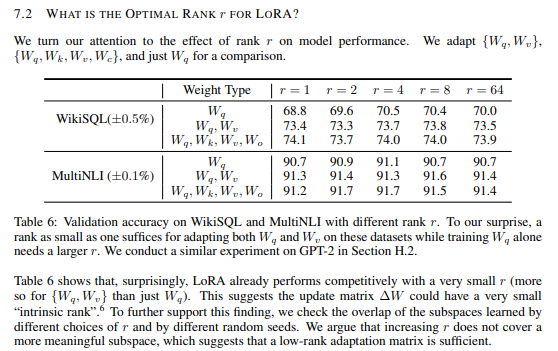


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

In [29]:
from peft import LoraConfig, get_peft_model

# set our rank (higher value is more memory/better performance)
lora_r = 16

# set our dropout (default value)
lora_dropout = 0.1

# rule of thumb: alpha should be (lora_r * 2)
lora_alpha = 32

# construct our LoraConfig with the above hyperparameters
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM"
)

Now that we have our PEFT config - we need to convert our model into a PEFT model!

We can use the convenient helper function `get_peft_model` to do so.

Documentation found [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/mapping.py#L98)!

In [30]:
model = get_peft_model(
    model,
    peft_config
)

print_trainable_parameters(model)

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


In [31]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

#### ❓Question #4:

What modules (or groupings of layers) did we apply LoRA too - and how can we tell from the model summary?

**ANSWER:**

LoRA was implemented on every Linear and Linear4bit layer in the model. The model summary confirms this, as it shows that only the linear layers have trainable parameters.



## Task #4: Training the Model

Now we'll be training our model with the created dataset!



### Setting up Training

The `SFTConfig` class contains all the usual suspects - these are the same hyper-parameters you know and love from from previous notebooks!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [42]:
from trl import SFTConfig

max_seq_length = 1024

args = SFTConfig(
  output_dir = "llama381binstruct_summarize_short_new",
  #num_train_epochs=5,
  max_steps = 500, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 1,
  warmup_steps = 30,
  logging_steps=10,
  #evaluation_strategy="epoch",
  eval_strategy="steps",
  eval_steps=25, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2e-4,
  lr_scheduler_type='linear',
  dataset_kwargs={
        "add_special_tokens" : False,
        "append_concat_token" : False,
  },
  max_seq_length=max_seq_length,
  packing=True,
)

#### ❓Question #5:

Describe what the following parameters are doing:

- `warmup_steps` - This defines the number of steps during which the model gradually increases its learning rate from 0 to the value specified in the learning_rate parameter.
- `learning_rate` - This indicates the rate at which the model adjusts its weights.

- `lr_scheduler_type` - This specifies the type of learning rate scheduler to be used. In this instance, it is a linear scheduler.





> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

In [43]:
from trl import SFTTrainer

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  tokenizer=tokenizer,
  formatting_func=create_prompt,
  args=args,
  train_dataset=legal_dataset["train"],
  eval_dataset=legal_dataset["validation"]
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:520: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:431: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


> NOTE: The following cell should take ~45min. or so to complete on a T4 GPU with the pre-set hyper-parameters.

In [34]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
25,1.746000,1.234201
50,0.698800,1.410218
75,0.421400,1.624539
100,0.148700,1.969292
125,0.089200,2.097624
150,0.044800,2.118597
175,0.027400,2.198464
200,0.014400,2.229100
225,0.012100,2.251637
250,0.009300,2.372507


TrainOutput(global_step=500, training_loss=0.18991226030513644, metrics={'train_runtime': 2575.5139, 'train_samples_per_second': 0.194, 'train_steps_per_second': 0.194, 'total_flos': 2.3183977611264e+16, 'train_loss': 0.18991226030513644, 'epoch': 26.31578947368421})

## Task #5: Share Your Model!

Normally, we would only seek to push the LoRA adapters to the hub. This is a lightweight and memory efficient way to push this model - as you can pull the base model down as part of the inference pipeline.

However, if you want to leverage the one-click-deploy features of Hugging Face, you'll need to first `merge_and_unload()` the model and push the resulting model to the hub. This process will merge the LoRA weights back into the base model.

> NOTE: If you run into issues during upload - please ensure you're using a HF Token with `WRITE` access!

In [35]:
from huggingface_hub import notebook_login

notebook_login()

In [46]:
trainer.push_to_hub("ai-maker-space/llama381binstruct_summarize_short_new")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.50k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dgutierrez/llama381binstruct_summarize_short_new/commit/41b3e7e83f9937112525a0edd6d2441fa3af267f', commit_message='ai-maker-space/llama381binstruct_summarize_short_new', commit_description='', oid='41b3e7e83f9937112525a0edd6d2441fa3af267f', pr_url=None, pr_revision=None, pr_num=None)

### Compare Outputs

Let's see how our model fairs at this task, now!

In [47]:
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


#### ❓Question #6:

What does the `merge_and_unload()` method do?

> NOTE: Check out the [documentation](https://huggingface.co/docs/trl/v0.7.11/use_model) or the [source code](https://github.com/huggingface/peft/blob/096fe537370cf8a2cb55cc9bd05c7812ca919405/src/peft/tuners/lora/model.py#L685) to find out!

**ANSWER:**


The merge_and_unload() method combines the LoRA weights with the base model, resulting in a new model that includes the LoRA weights integrated into the base model.

In [48]:
generate_response(create_prompt(legal_dataset["test"][1], include_response=False),
                  merged_model,
                  tokenizer)

"\n\nHere's a short human-readable summary:\n\n**Your Content on YouTube**\n\nWhen you upload videos or comments to YouTube, you retain ownership, but you grant YouTube a license to use, share, and display your content. This license is worldwide, non-exclusive, and free, and allows YouTube to use your content for its business purposes. You also grant other users a license to access and use your content through the service.\n\n**Key Points:**\n\n* You're responsible for your content and its consequences.\n* You must have the right to share the content you upload.\n* YouTube can use, share, and display your content, but you still own it.\n* The license for your content ends when you remove it, but YouTube may keep a copy.\n* You can't upload content that infringes on others' intellectual property rights or goes against YouTube's community guidelines.\n* YouTube doesn't endorse or support the opinions expressed in user content and will remove infringing content if notified.<|eot_id|>"

Let's look at the base model response:

> **Using YouTube Content**\n\nYou can access YouTube content for personal, non-commercial use through the website or app. You can only download content if a "download" link is provided by YouTube. You need permission from YouTube or the content owner to:\n\n* Copy, reproduce, distribute, transmit, broadcast, display, sell, or license content for any other purpose.\n* Use content for any purpose other than personal, non-commercial use.\n\nYouTube and its owners retain all rights not explicitly granted in the terms of service.

Now the fine-tuned response:

> **Using YouTube Content**\n\n* You can access and use YouTube content for personal use and as intended by the service.\n* You can only download content if a download link is explicitly provided by YouTube.\n* You need permission from YouTube or the content owner to use, copy, reproduce, distribute, or sell content for any purpose other than personal use.



We can see that, directionally, our model is getting much closer to our desired results with only *100* steps of training.

Let's try another example to make sure it wasn't a fluke!

In [49]:
legal_dataset["test"][3]["original_text"]

'subject to your compliance with these terms niantic grants you a limited nonexclusive nontransferable non sublicensable license to download and install a copy of the app on a mobile device and to run such copy of the app solely for your own personal noncommercial purposes. except as expressly permitted in these terms you may not a copy modify or create derivative works based on the app b distribute transfer sublicense lease lend or rent the app to any third party c reverse engineer decompile or disassemble the app or d make the functionality of the app available to multiple users through any means. niantic reserves all rights in and to the app not expressly granted to you under these terms. if you accessed or downloaded the app from the apple store then you agree to use the app only a on an apple branded product or device that runs ios apple s proprietary operating system software and b as permitted by the usage rules set forth in the apple store terms of service. if you accessed or d

In [50]:
generate_response(create_prompt(legal_dataset["test"][3], include_response=False),
                  merged_model,
                  tokenizer)

'\n\nHere is a short human-readable summary of the legal content:\n\n**License to Use the App**\n\nNiantic grants you a limited, non-exclusive license to use the app on your personal mobile device for non-commercial purposes.\n\n**Restrictions on Use**\n\n* You cannot copy, modify, distribute, transfer, sublicense, or rent the app.\n* You cannot reverse engineer, decompile, or disassemble the app.\n* You cannot make the app available to multiple users through any means.\n\n**Responsibility**\n\n* Niantic is responsible for the app and its functionality.\n* Apple (or other app providers) is not responsible for the app, except to the extent of refunding the purchase price if the app does not meet warranty standards.\n\n**Intellectual Property and Export Laws**\n\n* Niantic is responsible for addressing any intellectual property infringement claims related to the app.\n* You must comply with US and foreign export laws and regulations when using the app.\n\n**Representations and Warranties

In [51]:
# Ground Truth Summary
legal_dataset["test"][3]["reference_summary"]

'don t copy modify resell distribute or reverse engineer this app.'

Lets look at the base model response:

>  **Permission to Use Your Content**\n\nWhen you create content for our game, you grant us permission to:\n\n* Use your content as we see fit\n* Make copies of your content\n* Modify or adapt your content\n* Allow others to use, copy, modify, or adapt your content\n\nIf you don't want to give us this permission, don't create content for our game.

And the fine-tuned model:

> **Permission for Game Content**\n\nWhen you share content on our game, you agree to let us:\n\n* Use, modify, and adapt your content\n* Allow others to use, modify, and adapt your content\n* This permission is permanent and can't be taken back\n* Consider carefully before sharing content, as it will be public and may be used in ways you don't like.

And again, we can see that the model performs the task *better* than the original un-fine-tuned model, in that the language is less formal - though there is still work to do.

**MODEL UPLOADED IN HUGGING FACE**
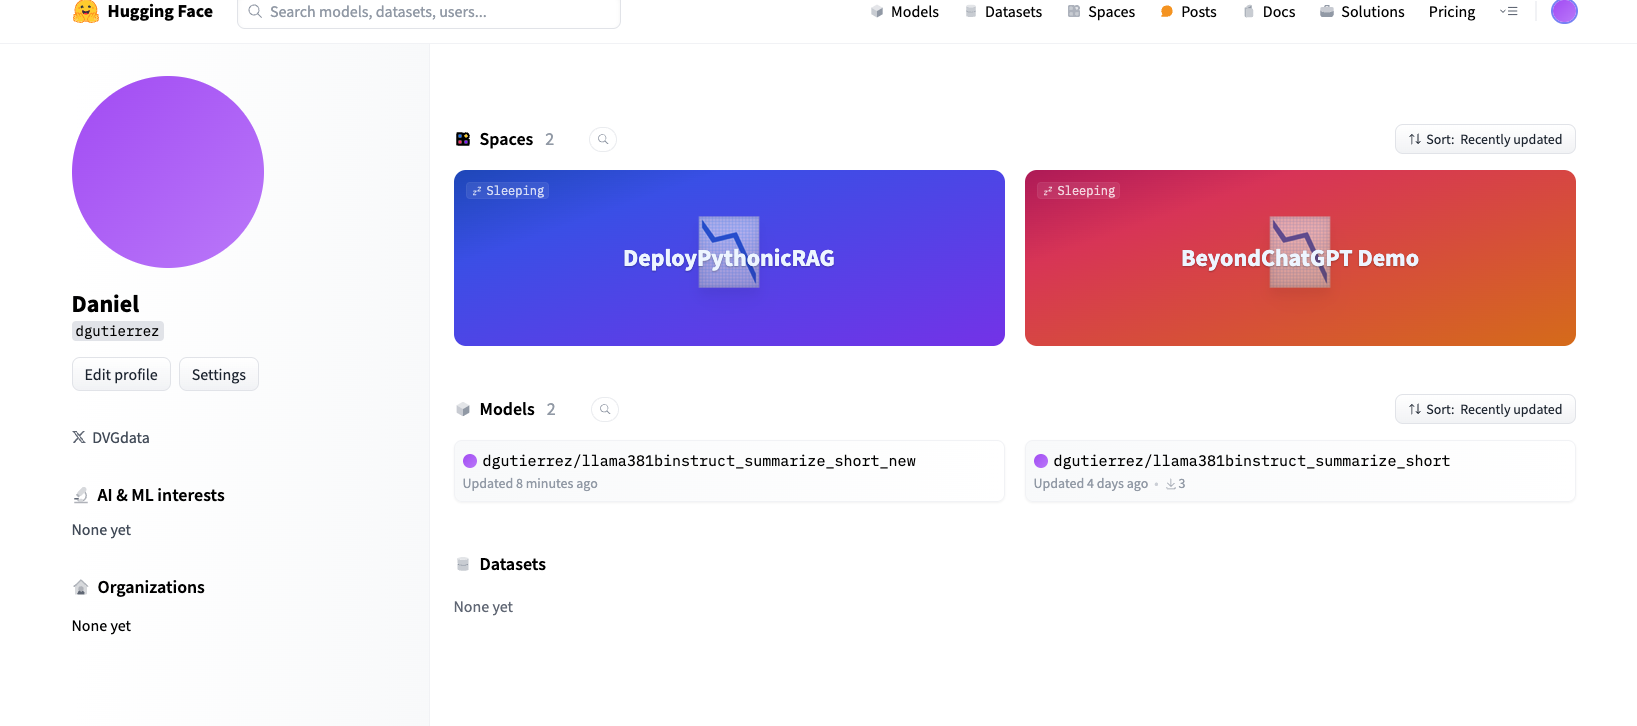
